# **Business Problem - Loan Default Prediction**




SuperLender is a local digital lending company. SuperLender wants to build machine learning model to lower the risk of loan default and deliver profitable and high-impact loan alternative. Now, try to predict if a loan was good or bad. This is binary classification business problem, where Good is 1 and Bad is 0.
Source : https://zindi.africa/competitions/data-science-nigeria-challenge-1-loan-default-prediction

We are not given the relative impact of false negatives (versus other outcomes). You are free to make your own assumptions. 

# **Executive Summary - BLUF**

We find that most of the models have AUC and Accuracy ranging from 50-65%. Recall values averaged between 80-90%. The performance of all the models was found to be more or less the same, with the **logistic regression model minutely outperforming the others in terms of AUC, accuracy and ROC**. The model had an AUC of 0.63, accuracy of 0.75, and an ROC score of 0.62. However, we caveat that no model achieved a level of accuracy that would qualify them as a standalone tool for loan prediction. 

Analysis shows about 8% of the instances have propensities in the [0.3,0.7] range, but the misclassified instances vary across the classifiers.

We reccommend that the lending company work with a more robust dataset that includes more predictors such as previous loan history etc. Additional data modelling tools will also need to be looked at in order to improve predictive accuracy. 

# **Data Description**


## a) Demographic data (traindemographics.csv)
- **customerid** (Primary key used to merge to other data)
- **birthdate** (date of birth of the customer)
- **bank_account_type** (type of primary bank account)
- **longitude_gps**
- **latitude_gps**
- **bank_name_clients** (name of the bank)
- **bank_branch_clients** (location of the branch - not compulsory - so missing in a lot of the cases)
- **employment_status_clients** (type of employment that customer has)
- **level_of_education_clients** (highest level of education)

## b) Performance data (trainperf.csv)
- **customerid** (Primary key used to merge to other data)
-**systemloanid** (The id associated with the particular loan. The same customerId can have multiple systemloanid’s for each loan he/she has taken out)
- **loannumber** (The number of the loan that you have to predict)
- **approveddate** (Date that loan was approved)
- **creationdate** (Date that loan application was created)
- **loanamount** (Loan value taken)
- **totaldue** (Total repayment required to settle the loan - this is the capital loan value disbursed +interest and fees)
- **termdays** (Term of loan)
- **referredby** (customerId of the customer that referred this person - is missing, then not referred)
- **good_bad_flag** (good = settled loan on time; bad = did not settled loan on time) - this is the target variable that we need to predict

# **Instruction** 

Using the data, and code from the M4 classification Python notebooks, and other resources, as appropriate:

* Formulate a business problem that can be solved by classifiers, identify appropriate metrics to evaluate the suitability of a classifier solution for the business problem, stage a horse race of classifiers for the business problem, documenting your results, and determine if the classification results offer an appropriate solution to the business problem.

* Summarize your findings and an action items in a few sentences at the end of the notebook (in a section titled “Conclusion”). Be sure to offer the Bottom Line Up Front (BLUF) at the start of the Conclusion.

* Submit your notebook file on Blackboard, double checking that you have submitted the correct file.

Download the **"traindemographics.csv"** and **"trainperf.csv"** dataset from the source. 

**Source** : https://zindi.africa/competitions/data-science-nigeria-challenge-1-loan-default-prediction/data
Start the hackathon by running the code below. 

When you read the csv files from the google drive, locate the files under the given names. These two files will be merged. 
- **file_1** is **"trainperf.csv"**
- **file_2** is **"traindemographics.csv"**

# **Libraries**

In [ ]:
# Basic Libraries
import pandas as pd
import seaborn as sns

import numpy as np
from numpy import mean
from numpy import std

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.stats.mstats import winsorize
import scipy.stats as ss
import math
import seaborn as sns
from datetime import datetime

In [ ]:
# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

In [ ]:
# LightGBM
#!pip install lightgbm
from lightgbm import LGBMClassifier

In [ ]:
# imblearn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline

# **Read Dataset**

In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Read two files 
file_1 = "/content/drive/MyDrive/Colab Notebooks/trainperf.csv"   # adapt this as needed to the file structure on your Google drive
df1 = pd.read_csv(file_1) # read in csv file

file_2= "/content/drive/MyDrive/Colab Notebooks/traindemographics.csv"   
df2 = pd.read_csv(file_2) # read in csv file

In [ ]:
# Merge two files using inner join
result = pd.merge(df1, df2, how='inner', on='customerid')

# **EDA**

In [ ]:
result.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,NaN,Good,1972-01-15 00:00:00.000000,Other,3.432010,6.433055,Diamond Bank,NaN,Permanent,Post-Graduate
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41.000000,2017-07-05 16:04:18.000000,15000.0,17250.0,30,NaN,Good,1985-08-23 00:00:00.000000,Savings,3.885298,7.320700,GT Bank,"DUGBE,IBADAN",Permanent,Graduate
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57.000000,2017-07-06 13:52:51.000000,20000.0,22250.0,15,NaN,Good,1984-09-18 00:00:00.000000,Other,11.139350,10.292041,EcoBank,NaN,Permanent,NaN
3,8a85890754145ace015429211b513e16,301999343,3,2017-07-27 19:00:41.000000,2017-07-27 18:00:35.000000,10000.0,11500.0,15,NaN,Good,1977-10-10 00:00:00.000000,Savings,3.985770,7.491708,First Bank,NaN,Permanent,NaN
4,8a858970548359cc0154883481981866,301962360,9,2017-07-03 23:42:45.000000,2017-07-03 22:42:39.000000,40000.0,44000.0,30,NaN,Good,1986-09-07 00:00:00.000000,Other,7.457913,9.076574,GT Bank,NaN,Permanent,Primary


In [ ]:
# customer ID and System ID are deleted, as they don't add information to the model
# bank_branch_clients is deleted to reduce the # of features after encoding
# loannumber, approveddate, creationdate, and referredby are deleted, as they don't add much value 
result = result.drop(columns=['customerid', 'systemloanid','bank_branch_clients','loannumber','approveddate','creationdate','referredby'])

In [ ]:
# Shape of df
print("Shape", result.shape)

# Check data types
print(result.info())

Shape (3277, 11)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3277 entries, 0 to 3276
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   loanamount                  3277 non-null   float64
 1   totaldue                    3277 non-null   float64
 2   termdays                    3277 non-null   int64  
 3   good_bad_flag               3277 non-null   object 
 4   birthdate                   3277 non-null   object 
 5   bank_account_type           3277 non-null   object 
 6   longitude_gps               3277 non-null   float64
 7   latitude_gps                3277 non-null   float64
 8   bank_name_clients           3277 non-null   object 
 9   employment_status_clients   2784 non-null   object 
 10  level_of_education_clients  443 non-null    object 
dtypes: float64(4), int64(1), object(6)
memory usage: 307.2+ KB
None


In [ ]:
# Describe Dataset 
print("\n DESCRIBE\n",result.describe())


 DESCRIBE
          loanamount      totaldue     termdays  longitude_gps  latitude_gps
count   3277.000000   3277.000000  3277.000000    3277.000000   3277.000000
mean   17830.332621  21280.569271    29.258468       4.534611      7.292799
std    10742.059352  11929.316405    11.405342       7.916626      3.268758
min    10000.000000  10000.000000    15.000000    -118.247009    -33.868818
25%    10000.000000  13000.000000    30.000000       3.354984      6.473645
50%    10000.000000  13000.000000    30.000000       3.587546      6.625954
75%    20000.000000  24500.000000    30.000000       6.478157      7.429882
max    60000.000000  68100.000000    90.000000     151.209290     71.228069


In [ ]:
# Check Skewness
print("\n SKEWNESS\n",result.skew())


 SKEWNESS
 loanamount       1.241791
totaldue         1.154553
termdays         1.875509
longitude_gps   -3.211137
latitude_gps     9.342461
dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


In [ ]:
# Check Kurtosis
print("\n kurtosis\n",result.kurtosis())


 kurtosis
 loanamount         0.620163
totaldue           0.283694
termdays           6.226940
longitude_gps    166.777991
latitude_gps     143.510897
dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


CORRELATION MATRIX
                loanamount  totaldue  termdays  longitude_gps  latitude_gps
loanamount       1.000000  0.994311  0.551188      -0.001301      0.010006
totaldue         0.994311  1.000000  0.621356      -0.001766      0.007852
termdays         0.551188  0.621356  1.000000       0.003204     -0.008003
longitude_gps   -0.001301 -0.001766  0.003204       1.000000     -0.253237
latitude_gps     0.010006  0.007852 -0.008003      -0.253237      1.000000





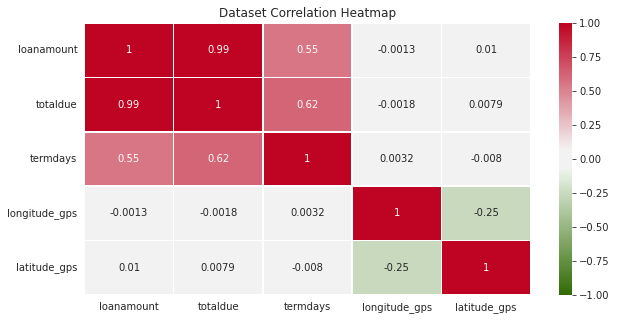



COVARIANCE MATRIX
                  loanamount      totaldue  ...  longitude_gps  latitude_gps
loanamount     1.153918e+08  1.274164e+08  ...    -110.676598    351.352890
totaldue       1.274164e+08  1.423086e+08  ...    -166.802134    306.162404
termdays       6.752983e+04  8.454043e+04  ...       0.289317     -0.298350
longitude_gps -1.106766e+02 -1.668021e+02  ...      62.672963     -6.553162
latitude_gps   3.513529e+02  3.061624e+02  ...      -6.553162     10.684782

[5 rows x 5 columns]





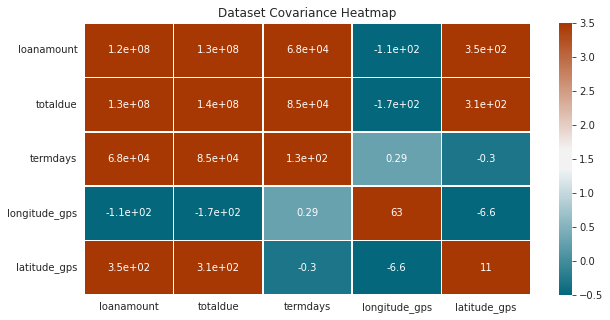

In [ ]:
# Multivariate numerical descriptive statistics

#Correlation Matrix
print("CORRELATION MATRIX\n",result.corr())
print("\n\n")

#Correlation Matrix as a Heatmap
sns.set_style('darkgrid')
plt.figure(figsize = (10,5))
cmap = sns.diverging_palette(120, 10, l = 40, s = 99, sep = 20, center = 'light', as_cmap = True) 
sns.heatmap((result).corr(), vmin = -1, vmax = 1, annot = True, cmap = cmap, lw = .5, linecolor = 'white')
plt.title("Dataset Correlation Heatmap")
plt.show()

# Covariance Matrix
print("\n\nCOVARIANCE MATRIX\n",result.cov())
print("\n\n")

#Covariance Matrix as a Heatmap
sns.set_style('darkgrid')
plt.figure(figsize = (10,5))
cmap = sns.diverging_palette(220, 20, l = 40, s = 99, sep = 20, center = 'light', as_cmap = True) 
sns.heatmap((result).cov(), vmin = -0.5, vmax = 3.5, annot = True, cmap = cmap, lw = .5, linecolor = 'white')
plt.title("Dataset Covariance Heatmap")
plt.show()

#**Encoding**

In [ ]:
# Encode categorical target variable 
good_bad_flag_mapping = {'Good': 1,
                         'Bad' : 0}
result['good_bad_flag'] = result['good_bad_flag'].map(good_bad_flag_mapping)
print('Label-encoded good_bad_flag:\n',result['good_bad_flag'],"\n\n")

Label-encoded good_bad_flag:
 0       1
1       1
2       1
3       1
4       1
       ..
3272    0
3273    0
3274    0
3275    0
3276    0
Name: good_bad_flag, Length: 3277, dtype: int64 




1    2563
0     714
Name: good_bad_flag, dtype: int64

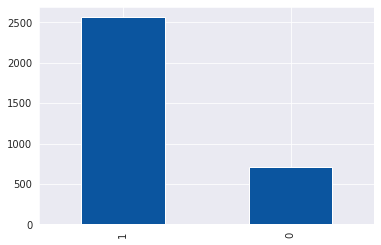

In [ ]:
# Count good and bad 
result["good_bad_flag"].value_counts().plot.bar()
result["good_bad_flag"].value_counts()

In [ ]:
# rename less frequent categories of bank_name_clients to 'Other'
need = result['bank_name_clients'].value_counts().index[:2]
result['bank_name_clients'] = np.where(result['bank_name_clients'].isin(need), result['bank_name_clients'], 'OTHER')

valCount = result['bank_name_clients'].value_counts()
print (valCount)

OTHER         1637
GT Bank       1210
First Bank     430
Name: bank_name_clients, dtype: int64


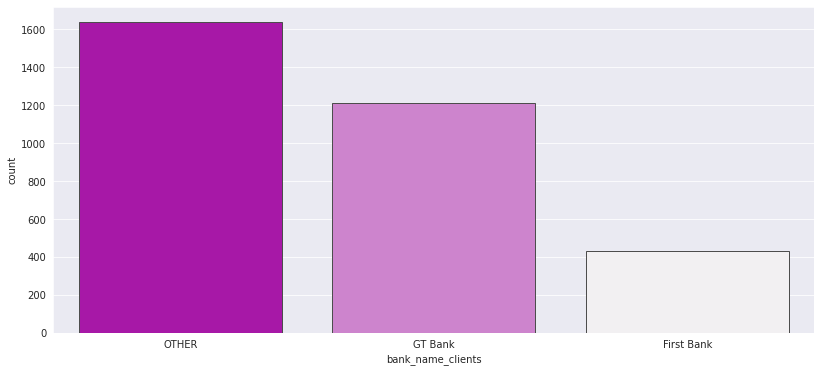

In [ ]:
# Univariate Bar Charts

plt.figure(figsize = (30,6))
plt.subplot(1,2,1)
sns.countplot(  x="bank_name_clients", data=result,palette="light:m_r",
    edgecolor=".3")
plt.show()

In [ ]:
# rename less frequent categories of employment_status_clients to 'Other'
need = result['employment_status_clients'].value_counts().index[:3]
result['employment_status_clients'] = np.where(result['employment_status_clients'].isin(need), result['employment_status_clients'], 'OTHER')

valCount = result['employment_status_clients'].value_counts()
print (valCount)

Permanent        2348
OTHER             541
Self-Employed     277
Student           111
Name: employment_status_clients, dtype: int64


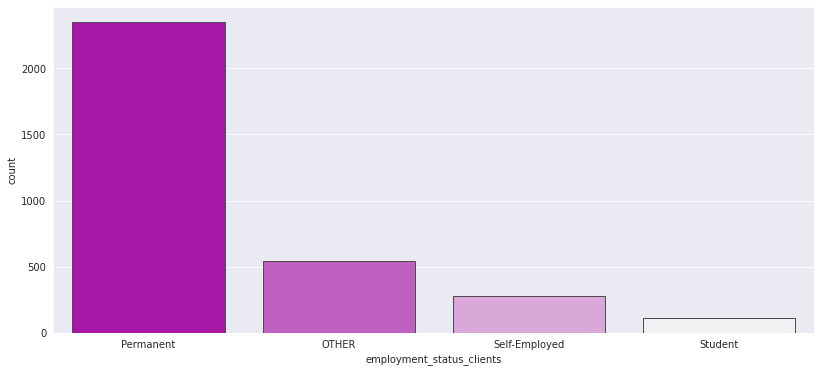

In [ ]:
# Univariate Bar Charts

plt.figure(figsize = (30,6))
plt.subplot(1,2,2)
sns.countplot(  x="employment_status_clients", data=result,palette="light:m_r",
    edgecolor=".3")
plt.show()

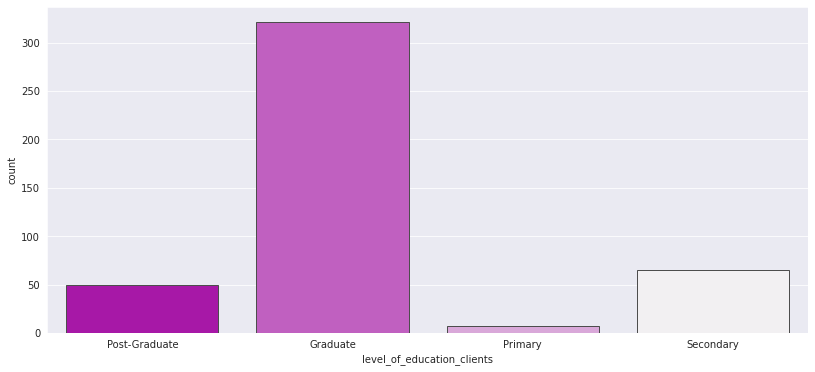

In [ ]:
# Univariate Bar Charts

plt.figure(figsize = (30,6))
plt.subplot(1,2,2)
sns.countplot(  x="level_of_education_clients", data=result,palette="light:m_r",
    edgecolor=".3")
plt.show()

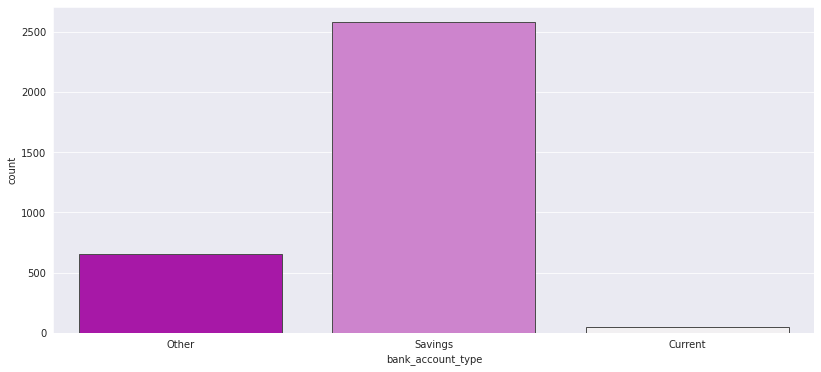

In [ ]:
# Univariate Bar Charts

plt.figure(figsize = (30,6))
plt.subplot(1,2,2)
sns.countplot(  x="bank_account_type", data=result,palette="light:m_r",
    edgecolor=".3")
plt.show()

In [ ]:
# change birthday to age. New column age is created
import pandas as pd
from datetime import datetime, date

  
# This function converts given date to age
def age(born):
    born = datetime.strptime(born, '%Y-%m-%d %H:%M:%S.%f').date()
    today = date.today()
    return today.year - born.year - ((today.month, 
                                      today.day) < (born.month, 
                                                    born.day))
  
result['Age'] = result['birthdate'].apply(age)
  
display(result)

,loanamount,totaldue,termdays,good_bad_flag,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients,level_of_education_clients,Age
0,30000.0,34500.0,30,1,1972-01-15 00:00:00.000000,Other,3.432010,6.433055,OTHER,Permanent,Post-Graduate,50
1,15000.0,17250.0,30,1,1985-08-23 00:00:00.000000,Savings,3.885298,7.320700,GT Bank,Permanent,Graduate,36
2,20000.0,22250.0,15,1,1984-09-18 00:00:00.000000,Other,11.139350,10.292041,OTHER,Permanent,NaN,37
3,10000.0,11500.0,15,1,1977-10-10 00:00:00.000000,Savings,3.985770,7.491708,First Bank,Permanent,NaN,44
4,40000.0,44000.0,30,1,1986-09-07 00:00:00.000000,Other,7.457913,9.076574,GT Bank,Permanent,Primary,35
...,...,...,...,...,...,...,...,...,...,...,...,...
3272,10000.0,11500.0,15,0,1979-03-22 00:00:00.000000,Savings,3.302387,6.568690,GT Bank,OTHER,NaN,42
3273,10000.0,13000.0,30,0,1989-12-04 00:00:00.000000,Savings,4.607358,8.460608,OTHER,Permanent,NaN,32
3274,10000.0,11500.0,15,0,1989-11-21 00:00:00.000000,Savings,3.976842,7.409129,First Bank,Permanent,NaN,32
3275,10000.0,13000.0,30,0,1990-06-11 00:00:00.000000,Savings,3.986089,7.386796,OTHER,Permanent,NaN,31


In [ ]:
# drop birthday
result = result.drop(columns=['birthdate'])

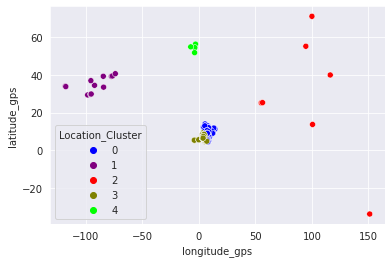

In [ ]:
# k-means clustering to cluster longitude and latitude 
# define the model
from sklearn.cluster import KMeans
model = KMeans(n_clusters=5)
# fit the model
model.fit(result[['longitude_gps','latitude_gps']])
# assign a cluster to each example
yhat = pd.DataFrame(model.predict(result[['longitude_gps','latitude_gps']]),columns=['Location_Cluster'])
if 'Location_Cluster' not in result:
  result = pd.concat([result.set_index(yhat.index),yhat],axis=1)
else:
  result['Location_Cluster'] = yhat
colors = ['#747FE3', '#8EE35D', '#E37346']
sns.set_palette(sns.color_palette(colors))
sns.scatterplot(x='longitude_gps', y='latitude_gps', data=result, hue='Location_Cluster', palette = "brg")


In [ ]:
# create dummy variables for categorical variables 
result = pd.get_dummies(data=result, columns=['bank_name_clients','employment_status_clients','bank_account_type','level_of_education_clients'])

In [ ]:
# drop latitude & longitude
result = result.drop(columns=['longitude_gps','latitude_gps'])

In [ ]:
# Review columns in dataframe
result.columns

Index(['loanamount', 'totaldue', 'termdays', 'good_bad_flag', 'Age',
       'Location_Cluster', 'bank_name_clients_First Bank',
       'bank_name_clients_GT Bank', 'bank_name_clients_OTHER',
       'employment_status_clients_OTHER',
       'employment_status_clients_Permanent',
       'employment_status_clients_Self-Employed',
       'employment_status_clients_Student', 'bank_account_type_Current',
       'bank_account_type_Other', 'bank_account_type_Savings',
       'level_of_education_clients_Graduate',
       'level_of_education_clients_Post-Graduate',
       'level_of_education_clients_Primary',
       'level_of_education_clients_Secondary'],
      dtype='object')

#**Visualizations**



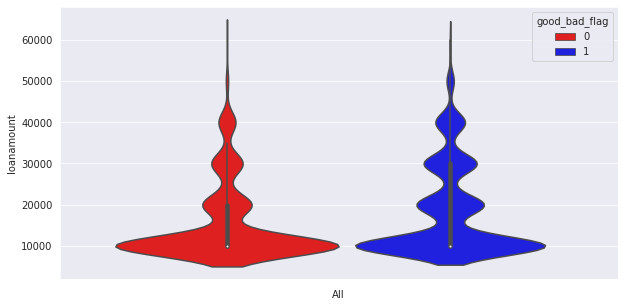

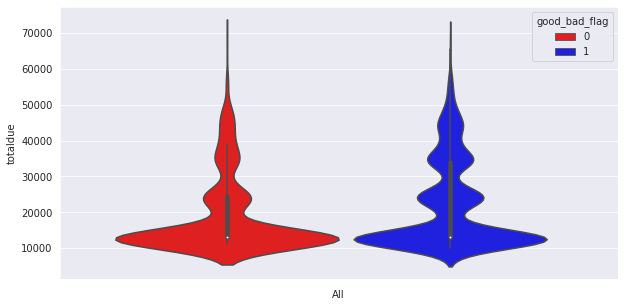

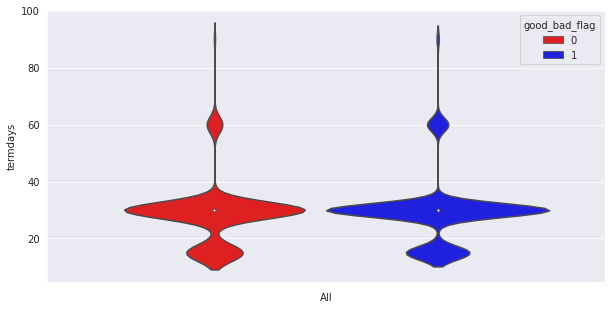

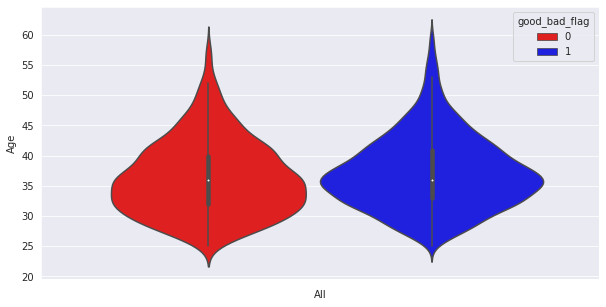

In [ ]:
# Violinplots for quant variables
result["All"] = ""
for i in result.columns:
  if (result.dtypes[i] == 'int64' or result.dtypes[i] == 'float64') and ((i != 'All') and (i != 'good_bad_flag')):
    plt.figure(figsize = (10,5))
    sns.violinplot(x = 'All',y = i, hue = "good_bad_flag", data = result,palette = {True:'blue', False:'red'})
    plt.show()
result.drop('All',axis=1)

result = result.drop(columns=['All'])

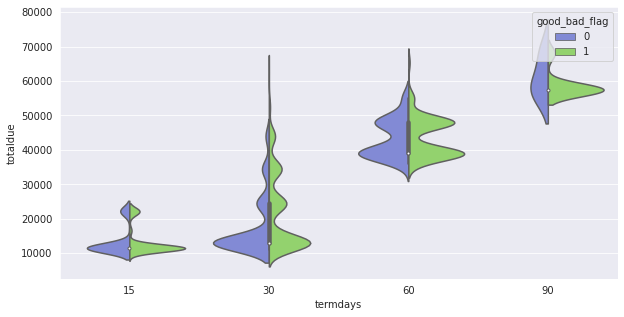

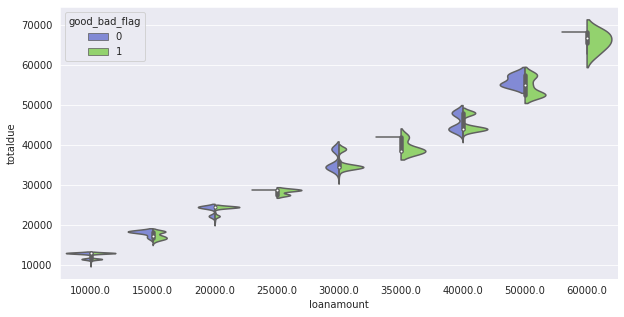

In [ ]:
# Bivariate violinplots
plt.figure(figsize = (10,5))
sns.violinplot(x ="termdays", y ="totaldue", hue ="good_bad_flag",data = result, split = True)
plt.show()
plt.figure(figsize = (10,5))
sns.violinplot(x ="loanamount", y ="totaldue", hue ="good_bad_flag",data = result, split = True)
plt.show()

# **Missing values & duplicates**

In [ ]:
# Count total NaN at each column in a DataFrame
print(" \nCount total NaN at each column in a DataFrame : \n\n",
      result.isnull().sum())

 
Count total NaN at each column in a DataFrame : 

 loanamount                                  0
totaldue                                    0
termdays                                    0
good_bad_flag                               0
Age                                         0
Location_Cluster                            0
bank_name_clients_First Bank                0
bank_name_clients_GT Bank                   0
bank_name_clients_OTHER                     0
employment_status_clients_OTHER             0
employment_status_clients_Permanent         0
employment_status_clients_Self-Employed     0
employment_status_clients_Student           0
bank_account_type_Current                   0
bank_account_type_Other                     0
bank_account_type_Savings                   0
level_of_education_clients_Graduate         0
level_of_education_clients_Post-Graduate    0
level_of_education_clients_Primary          0
level_of_education_clients_Secondary        0
dtype: int64


In [ ]:
result.isnull().any()

loanamount                                  False
totaldue                                    False
termdays                                    False
good_bad_flag                               False
Age                                         False
Location_Cluster                            False
bank_name_clients_First Bank                False
bank_name_clients_GT Bank                   False
bank_name_clients_OTHER                     False
employment_status_clients_OTHER             False
employment_status_clients_Permanent         False
employment_status_clients_Self-Employed     False
employment_status_clients_Student           False
bank_account_type_Current                   False
bank_account_type_Other                     False
bank_account_type_Savings                   False
level_of_education_clients_Graduate         False
level_of_education_clients_Post-Graduate    False
level_of_education_clients_Primary          False
level_of_education_clients_Secondary        False


In [ ]:
# Check for duplicates and remove if there is any 
result.drop_duplicates(inplace = True)
print('\n Duplicates\n',result.duplicated().sum())


 Duplicates
 0


#**Pre-processing - Skewness correction**



In [ ]:
# pick numerical variables and set them as X
X = result[['loanamount','totaldue','termdays','Age']]

In [ ]:
# Code for skewness correction (see source below)
# Depending upon the characteritics of a feature (column), a log, Box-Cox or power transform is applied to normalize the distribution 

# -*- coding: utf-8 -*-
"""
Created on Sat Feb 23 14:42:46 2019
@author: DATAmadness
"""

##################################################
# A function that will accept a pandas dataframe
# and auto-transforms columns that exceeds threshold value
#  -  Offers choice between boxcox or log / exponential transformation
#  -  Automatically handles negative values
#  -  Auto recognizes positive /negative skewness

# Further documentation available here:
# https://datamadness.github.io/Skewness_Auto_Transform

def skew_autotransform(DF, include = None, exclude = None, plot = False, threshold = 1, exp = False):
    
    #Get list of column names that should be processed based on input parameters
    if include is None and exclude is None:
        colnames = DF.columns.values
    elif include is not None:
        colnames = include
    elif exclude is not None:
        colnames = [item for item in list(DF.columns.values) if item not in exclude]
    else:
        print('No columns to process!')
    
    #Helper function that checks if all values are positive
    def make_positive(series):
        minimum = np.amin(series)
        #If minimum is negative, offset all values by a constant to move all values to positive teritory
        if minimum <= 0:
            series = series + abs(minimum) + 0.01
        return series
    
    
    #Go through desired columns in DataFrame
    for col in colnames:
        #Get column skewness
        skew = DF[col].skew()
        transformed = True
        
        if plot:
            #Prep the plot of original data
            sns.set_style("darkgrid")
            sns.set_palette("Blues_r")
            fig, axes = plt.subplots(1, 2, figsize=(10, 5))
            #ax1 = sns.distplot(DF[col], ax=axes[0])
            ax1 = sns.histplot(DF[col], ax=axes[0], color="blue", label="100% Equities", kde=True, stat="density", linewidth=0)
            ax1.set(xlabel='Original ' + str(col))
        
        #If skewness is larger than threshold and positively skewed; If yes, apply appropriate transformation
        if abs(skew) > threshold and skew > 0:
            skewType = 'positive'
            #Make sure all values are positive
            DF[col] = make_positive(DF[col])
            
            if exp:
               #Apply log transformation 
               DF[col] = DF[col].apply(math.log)
            else:
                #Apply boxcox transformation
                DF[col] = ss.boxcox(DF[col])[0]
            skew_new = DF[col].skew()
         
        elif abs(skew) > threshold and skew < 0:
            skewType = 'negative'
            #Make sure all values are positive
            DF[col] = make_positive(DF[col])
            
            if exp:
               #Apply exp transformation 
               DF[col] = DF[col].pow(10)
            else:
                #Apply boxcox transformation
                DF[col] = ss.boxcox(DF[col])[0]
            skew_new = DF[col].skew()
        
        else:
            #Flag if no transformation was performed
            transformed = False
            skew_new = skew
        
        #Compare before and after if plot is True
        if plot:
            print('\n ------------------------------------------------------')     
            if transformed:
                print('\n %r had %r skewness of %2.2f' %(col, skewType, skew))
                print('\n Transformation yielded skewness of %2.2f' %(skew_new))
                sns.set_palette("Paired")
                #ax2 = sns.distplot(DF[col], ax=axes[1], color = 'r')
                ax2 = sns.histplot(DF[col], ax=axes[1], color="red", label="100% Equities", kde=True, stat="density", linewidth=0)
                ax2.set(xlabel='Transformed ' + str(col))
                plt.show()
            else:
                print('\n NO TRANSFORMATION APPLIED FOR %r . Skewness = %2.2f' %(col, skew))
                #ax2 = sns.distplot(DF[col], ax=axes[1])
                ax2 = sns.histplot(DF[col], ax=axes[1], color="blue", label="100% Equities", kde=True, stat="density", linewidth=0)
                ax2.set(xlabel='NO TRANSFORM ' + str(col))
                plt.show()
                

    return DF


 ------------------------------------------------------

 NO TRANSFORMATION APPLIED FOR 'loanamount' . Skewness = 0.82


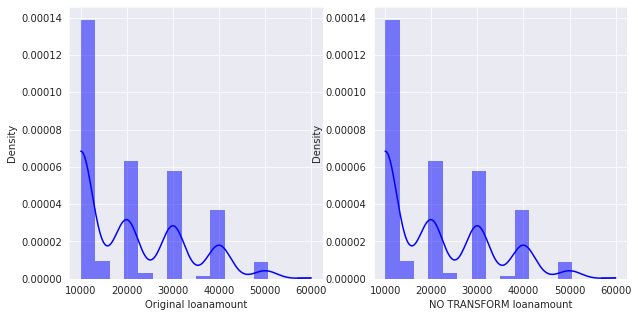


 ------------------------------------------------------

 NO TRANSFORMATION APPLIED FOR 'totaldue' . Skewness = 0.73


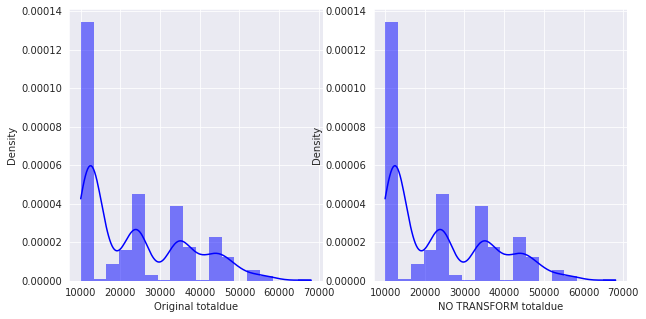


 ------------------------------------------------------

 'termdays' had 'positive' skewness of 1.69

 Transformation yielded skewness of -0.00


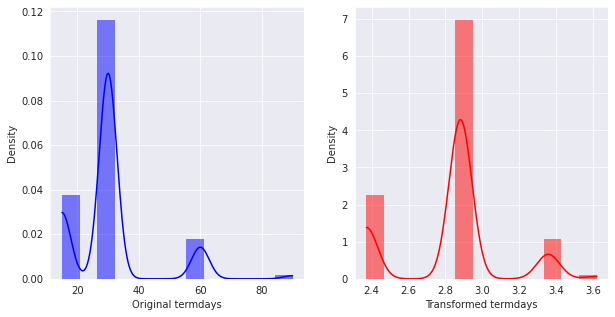


 ------------------------------------------------------

 NO TRANSFORMATION APPLIED FOR 'Age' . Skewness = 0.63


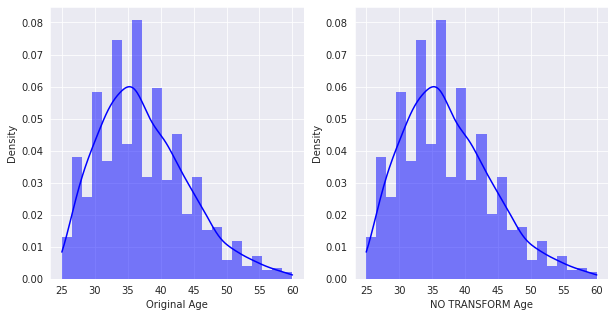

In [ ]:
# Use code above (adapted from https://github.com/datamadness/Automatic-skewness-transformation-for-Pandas-DataFrame) to correct skewness
# All the predictors are real-valued, so we can push them all through the skewness check/correction.
X = skew_autotransform(X.copy(deep=True), plot = True, exp = False, threshold = 1)

#**Pre-processing - Outliers**

In [ ]:
# Tukey Rule outliers
# As an alternative, you could use z-scores greater than 3 or less than -3.

cols = X.columns
#Tukey's method
def tukey_rule(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    upper_lim = data[col].quantile(0.5) + 2 * IQR
    lower_lim = data[col].quantile(0.5) - 2 * IQR
    outliers = []
    for index, x in enumerate(data[col]):
        if x < lower_lim or x >= upper_lim:
            outliers.append(index)
    return outliers

# Identify outliers
for i in cols:
  outliers_Tukey = tukey_rule(X,i)
  print("Column ",i,": ",outliers_Tukey)
  
# Windsorize X and check the results
print("Before", X.describe())
X_winsorized = X.copy(deep=True)
for i in cols:
  X_winsorized[i] = winsorize(X[i], limits=(0.05, 0.05))
print("After", X_winsorized.describe())

Column  loanamount :  [721, 970, 996, 1414, 1520, 1828]
Column  totaldue :  [721, 970, 996, 1414, 1828]
Column  termdays :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 

In [ ]:
#Review columns
result.columns

Index(['loanamount', 'totaldue', 'termdays', 'good_bad_flag', 'Age',
       'Location_Cluster', 'bank_name_clients_First Bank',
       'bank_name_clients_GT Bank', 'bank_name_clients_OTHER',
       'employment_status_clients_OTHER',
       'employment_status_clients_Permanent',
       'employment_status_clients_Self-Employed',
       'employment_status_clients_Student', 'bank_account_type_Current',
       'bank_account_type_Other', 'bank_account_type_Savings',
       'level_of_education_clients_Graduate',
       'level_of_education_clients_Post-Graduate',
       'level_of_education_clients_Primary',
       'level_of_education_clients_Secondary'],
      dtype='object')

#**Holdout Sample**


In [ ]:
X = result[['loanamount','totaldue','termdays','Age','Location_Cluster', 'bank_name_clients_First Bank',
       'bank_name_clients_GT Bank', 'bank_name_clients_OTHER',
       'employment_status_clients_OTHER',
       'employment_status_clients_Permanent',
       'employment_status_clients_Self-Employed',
       'employment_status_clients_Student', 'bank_account_type_Current',
       'bank_account_type_Other', 'bank_account_type_Savings',
       'level_of_education_clients_Graduate',
       'level_of_education_clients_Post-Graduate',
       'level_of_education_clients_Primary',
       'level_of_education_clients_Secondary']]
y=result['good_bad_flag']

In [ ]:
# Create holdout sample
# Note: split before doing any trasformations on the data!!!
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                     test_size=0.2,    # 80-20 training vs test set split
                     random_state=0, 
                     stratify=y)
print('Shape of X and y',X.shape, y.shape, '\nShape of training set X and y',X_train.shape, y_train.shape, '\nShape of test set X and y',X_test.shape, y_test.shape) 


Shape of X and y (2066, 19) (2066,) 
Shape of training set X and y (1652, 19) (1652,) 
Shape of test set X and y (414, 19) (414,)


In [ ]:
# Standardization of predictor
stdsc = StandardScaler()  
X_train_std = stdsc.fit_transform(X_train)   
X_test_std = stdsc.transform(X_test)             # transform uses the parameters from scaling the training data to transform our test data
print('Mean and Standard Deviation of column 0 in Training Data: ',X_train_std[:,0].mean(), '  ',X_train_std[:,0].std())
print('Mean and Standard Deviation of column 0 in Test Data: ',X_test_std[:,0].mean(), '  ',X_test_std[:,0].std())

Mean and Standard Deviation of column 0 in Training Data:  1.0752765371672218e-17    1.0
Mean and Standard Deviation of column 0 in Test Data:  -0.030530270902678035    1.012877824948289


#**Logistic Regression Classifier**

In [ ]:
# Get started with logistic regression (logit) classifier
clm = LogisticRegression(random_state=1, solver='sag',max_iter=1000,class_weight='balanced')     # Create logit model specifying random number seed to get repeatable results, use sag solver as lbfgs does not converge
                                                                 # The following guidance about solvers is taken from the sklearn documentation:
                                                                 # For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones;
                                                                 # For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss;
                                                                 # ‘liblinear’ is limited to one-versus-rest schemes.

clm.fit(X_train_std, np.ravel(y_train))            # Fit model using training data. Ravel converts a column vector into the required 1D array format.
y_pred = clm.predict(X_test_std)                                 # Apply model to test data
print('Logit: AUC = ', roc_auc_score(y_test,y_pred), ' recall =', recall_score(y_test, y_pred),' accuracy = ', accuracy_score(y_test, y_pred))    # Test set accuracy
print(confusion_matrix(y_true=y_test,y_pred=y_pred))                           # Confusion matrix
print("Logit Model Coefficients",list(clm.coef_))                # Logistic coefficients (can be used to assess which variables have the largest effect size in the model)

Logit: AUC =  0.5486217338369807  recall = 0.4758842443729904  accuracy =  0.5120772946859904
[[ 64  39]
 [163 148]]
Logit Model Coefficients [array([ 1.17489074, -0.75603332, -0.09438666,  0.1362833 ,  0.00325502,
        0.06427939,  0.00931083, -0.05596011, -0.02216139,  0.02745719,
       -0.00176895, -0.01873908,  0.11788609,  0.17901095, -0.21244359,
        0.00524416, -0.14691117,  0.01271898, -0.03575456])]


In [ ]:
# Examine propensities of logit model
logit_propensities = pd.DataFrame(clm.predict_proba(X_test_std)) 

# Create a dataframe showing actuals, predicted, and propensities 
y_pred = pd.DataFrame(y_pred)
y_pred.reset_index(drop = True , inplace = True)
y_test.reset_index(drop = True , inplace = True)
results = pd.concat([y_test, y_pred, logit_propensities[1]], axis=1)
results.columns= ['Actual','Predicted','Propensity']

#Compute percentage of instances with propensities in [lower_limit,upper_limit]
upper_limit = 0.7
lower_limit = 0.3
count = 0
for i in range(0,len(logit_propensities[1])):
  if((logit_propensities.loc[i,1] >= lower_limit) & (logit_propensities.loc[i,1] <= upper_limit)):
    count = count + 1
print('Percentage of test instances with propensity in [%1.2f, %1.2f]: %3.2f' % (lower_limit,upper_limit,100 * count/len(logit_propensities[1])))

# Show instances where predicted and actual differ
print('Instances for which actual and predicted differ:')
discrepancies = results.loc[results['Actual'] != results['Predicted']]
discrepancies

Percentage of test instances with propensity in [0.30, 0.70]: 82.85
Instances for which actual and predicted differ:


,Actual,Predicted,Propensity
1,1,0,0.382784
2,1,0,0.380910
5,0,1,0.585098
7,1,0,0.376251
10,1,0,0.460592
...,...,...,...
407,1,0,0.404921
410,0,1,0.580426
411,1,0,0.441271
412,1,0,0.466791


Test Accuracy: 0.751
[[  0 103]
 [  0 311]]


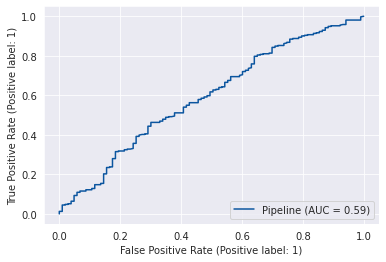

In [ ]:
# In pursuit of a competitive model with a much smaller number of predictors, create a pipeline that scales, performs PCA, and fits and scores a logit model
# Use weights to a) offset the effect of the imbalance in the target column (212 M out of 569 total), and b) emphasize that a false negative may be much worse than a false positive
from sklearn.decomposition import PCA
weights = {0:0.5, 1:0.5} # The weights are supposed to penalize errors in the classes. We assume that the false positives and false negatives are equal and so we
                         # we should set the weights to be {0:0.5, 1:0.5}.   
pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=5),
                        LogisticRegression(random_state=1,solver='sag',class_weight=weights))

pipe_lr.fit(X_train_std, np.ravel(y_train))
y_pred = pipe_lr.predict(X_test_std)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test_std, y_test))
print(confusion_matrix(y_test,y_pred,labels=[0,1]))                           # Confusion matrix
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(
        pipe_lr, X_test_std, y_test,
    )


In [ ]:
# Review propensities and misclassifications from PCA solution
pipe_lr_propensities = pd.DataFrame(clm.predict_proba(X_test_std)) 

# Create a dataframe showing actuals, predicted, and propensities 
y_pred = pd.DataFrame(y_pred)
y_pred.reset_index(drop = True , inplace = True)
y_test.reset_index(drop = True , inplace = True)
results = pd.concat([y_test, y_pred, pipe_lr_propensities[1]], axis=1)
results.columns= ['Actual','Predicted','Propensity']

#Compute percentage of instances with propensities in [lower_limit,upper_limit]
upper_limit = 0.7
lower_limit = 0.3
count = 0
for i in range(0,len(pipe_lr_propensities[1])):
  if((pipe_lr_propensities.loc[i,1] >= lower_limit) & (pipe_lr_propensities.loc[i,1] <= upper_limit)):
    count = count + 1
print('Percentage of test instances with propensity in [%1.2f, %1.2f]: %3.2f' % (lower_limit,upper_limit,100 * count/len(pipe_lr_propensities[1])))

# Show instances where predicted and actual differ
print('Instances for which actual and predicted differ:')
discrepancies = results.loc[results['Actual'] != results['Predicted']]
discrepancies


Percentage of test instances with propensity in [0.30, 0.70]: 82.85
Instances for which actual and predicted differ:


,Actual,Predicted,Propensity
0,0,1,0.391379
5,0,1,0.585098
6,0,1,0.370871
11,0,1,0.596621
12,0,1,0.385186
...,...,...,...
388,0,1,0.477550
390,0,1,0.578206
399,0,1,0.697592
410,0,1,0.580426


In [ ]:
# Add cross-validation
weights = {0:0.5, 1:0.5} # The weights are supposed to penalize errors in the classes. We assume that the false positives and false negatives are equal and so we
                         # we should set the weights to be {0:0.5, 1:0.5}.    
pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=5),
                        LogisticRegression(random_state=1,solver='sag',class_weight=weights))

scores = cross_val_score(pipe_lr, X, y, cv=5, n_jobs = -1,scoring='roc_auc')
print('CV AUC scores: {}'.format(scores))
print('CV AUC mean: {} and std deviation: {}'.format(np.mean(scores), np.std(scores)))

scores = cross_val_score(pipe_lr, X, y, cv=5, n_jobs = -1,scoring='recall')
print('CV recall scores: {}'.format(scores))
print('CV recall mean: {} and std deviation: {}'.format(np.mean(scores), np.std(scores)))

scores = cross_val_score(pipe_lr, X, y, cv=5, n_jobs = -1)
print('CV accuracy scores: {}'.format(scores))
print('CV accuracy mean: {} and std deviation: {}'.format(np.mean(scores), np.std(scores)))

CV AUC scores: [0.61057347 0.610302   0.61695353 0.64221735 0.67124961]
CV AUC mean: 0.6302591925037457 and std deviation: 0.023605378685295744
CV recall scores: [1. 1. 1. 1. 1.]
CV recall mean: 1.0 and std deviation: 0.0
CV accuracy scores: [0.75120773 0.75302663 0.75302663 0.75060533 0.75060533]
CV accuracy mean: 0.7516943303973517 and std deviation: 0.001109838332253735


#**Other Classifiers**

In [ ]:
# Try other classifiers

names = ["Decision Tree", "k Nearest Neighbors", "SVM", "MLP", "Random Forest", "XGBoost", "Light GBM"]
classifiers = [ 
    DecisionTreeClassifier(max_depth=5),
    KNeighborsClassifier(3),
    SVC(),
    MLPClassifier(hidden_layer_sizes=(20,20),alpha=1, max_iter=500),
    RandomForestClassifier(random_state=0, n_jobs=-1, n_estimators=100, max_depth=3),
    XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.1, 
                  n_estimators=100, max_depth=3),
    LGBMClassifier(boosting_type='gbdt', objective='binary', num_leaves=50,
                                learning_rate=0.1, bagging_fraction=0.9, feature_fraction=0.9, reg_lambda=0.2)]

for name, clf in zip(names, classifiers):
  pipe_many = make_pipeline(StandardScaler(),
                        PCA(n_components=5),
                        clf)
  scores = cross_val_score(estimator=pipe_many,
                             X=X_train,
                             y=np.ravel(y_train),
                             cv=10,     #Reduced to three folds for execution speed
                             n_jobs=1,
                            scoring='roc_auc')
  print("Classifier: ",name)
  print('CV AUC scores: {}'.format(scores))
  print('CV AUC mean:{} and std:{}'.format(np.mean(scores), np.std(scores)))
  print("\n\n")

Classifier:  Decision Tree
CV AUC scores: [0.57990244 0.48312195 0.61585366 0.502262   0.63453973 0.59598741
 0.62214792 0.60503541 0.59687254 0.62795043]
CV AUC mean:0.5863673485444532 and std:0.04952367206493443



Classifier:  k Nearest Neighbors
CV AUC scores: [0.43102439 0.46907317 0.47020063 0.51780094 0.5395358  0.50059009
 0.58949646 0.49488592 0.44708891 0.52350511]
CV AUC mean:0.4983201416207711 and std:0.04454439612812467



Classifier:  SVM
CV AUC scores: [0.58263415 0.56721951 0.58654603 0.53304485 0.51160504 0.51573564
 0.59913454 0.61319827 0.52517703 0.46036585]
CV AUC mean:0.549466089693155 and std:0.045484768695043434



Classifier:  MLP
CV AUC scores: [0.60702439 0.58497561 0.66266719 0.6007081  0.63355625 0.61585366
 0.66601101 0.65607789 0.65391424 0.64604642]
CV AUC mean:0.6326834775767113 and std:0.027252923616006113



Classifier:  Random Forest
CV AUC scores: [0.55541463 0.57443902 0.65942172 0.57848151 0.6404406  0.61319827
 0.67220692 0.64614477 0.67466562 0.

The leaderboard is now as follows:
Classifier performance results are ordered by AUC.

|**Classifier** |    AUC    |
|:----------------------|:------------:|
|Random Forest | 0.616 |
|Multilayer Perceptron | 0.629 |
|Decisiom Tree | 0.577 |
|Support Vector Machine | 0.531 |
|LightGBM | 0.491 |
|XGBoost | 0.574 |
|kNN | 0.492 |

We find the Logistic Regression performed better than all of the above 

#**Oversampling with SMOTE**

In [ ]:
# Try SMOTE with cross validation using a logit model
# Borrowing code from https://towardsdatascience.com/the-right-way-of-using-smote-with-cross-validation-92a8d09d00c7
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=17)
sm = SMOTE(random_state=17)
X_train_SMOTE, y_train_SMOTE = sm.fit_resample(X_train, y_train)

print("Shape before SMOTE: ", X_train.shape, y_train.shape, "\n")
print("Shape after SMOTE: ", X_train_SMOTE.shape, y_train_SMOTE.shape, "\n")

pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=17)],
                                ['scaler', StandardScaler()],    
                                ['pca', PCA(n_components = 5)],
                                ['classifier', LogisticRegression(random_state=17,
                                                                  max_iter=1000)]])

stratified_kfold = StratifiedKFold(n_splits=5,
                                       shuffle=True,
                                       random_state=11)
    
param_grid = {'classifier__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='roc_auc',    
                           cv=stratified_kfold,
                           n_jobs=-1)

grid_search.fit(X_train, np.ravel(y_train))
test_score = grid_search.score(X_test, y_test)

print(f'Test set ROC score: {test_score}')


print(grid_search.best_params_)
print(grid_search.best_estimator_)

Shape before SMOTE:  (1652, 19) (1652,) 

Shape after SMOTE:  (2484, 19) (2484,) 

Test set ROC score: 0.631739144007742
{'classifier__C': 0.001}
Pipeline(steps=[('smote', SMOTE(random_state=17)), ('scaler', StandardScaler()),
                ('pca', PCA(n_components=5)),
                ['classifier',
                 LogisticRegression(C=0.001, max_iter=1000, random_state=17)]])


1    1242
0    1242
Name: good_bad_flag, dtype: int64

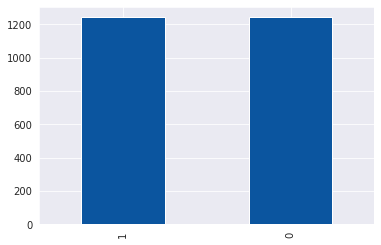

In [ ]:
# Count good and bad 
y_train_SMOTE.value_counts().plot.bar()
y_train_SMOTE.value_counts()

In [ ]:
from sklearn.feature_selection import RFE
rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=10)    #Selecting the top n features, from about 70, to improve model robustness.
j = rfe.fit(X_train,y_train)
print('Important Features\n',X.columns[rfe.support_])
rf = RandomForestClassifier()
j = rf.fit(rfe.transform(X_train), y_train)
print("\n Accuracy: ",rf.score(rfe.transform(X_test), y_test))

Important Features
 Index(['loanamount', 'totaldue', 'termdays', 'Age', 'Location_Cluster',
       'bank_name_clients_GT Bank', 'bank_name_clients_OTHER',
       'employment_status_clients_Permanent', 'bank_account_type_Savings',
       'level_of_education_clients_Graduate'],
      dtype='object')

 Accuracy:  0.6271186440677966


In [ ]:
#Try other classifiers with SMOTE and cross validation
names = ["Decision Tree", "k Nearest Neighbors", "SVM", "MLP", "Random Forest", "XGBoost", "Light GBM"]
classifiers = [  
    DecisionTreeClassifier(max_depth=5),
    KNeighborsClassifier(3),
    MLPClassifier(hidden_layer_sizes=(20,20),alpha=1, max_iter=500),
    SVC(),
    RandomForestClassifier(random_state=0, n_jobs=-1, n_estimators=100, max_depth=3),
    XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.1, 
                  n_estimators=100, max_depth=3),
    LGBMClassifier(boosting_type='gbdt', objective='binary', num_leaves=50,
                                learning_rate=0.1, bagging_fraction=0.9, feature_fraction=0.9, reg_lambda=0.2)]

# Build each classifier using the unbalanced TRAINING data, show decision region and petrformance of the unbalanced TEST data 
no_folds = 5 # number of folds desired for cross validation
kf = StratifiedKFold(n_splits=no_folds, shuffle=True, random_state=12345)
for name, clf in zip(names, classifiers):
  print('CLASSIFIER: ',name,'\n')
  mean_accuracy = 0.0
  mean_recall = 0.0
  mean_auc = 0.0
  for fold, (train_index, test_index) in enumerate(kf.split(X,y),1):
    X_train, X_test = X.iloc[list(train_index)], X.iloc[list(test_index)]
    y_train, y_test = y.iloc[list(train_index)], y.iloc[list(test_index)] 
    sm = SMOTE()
    X_train_SMOTE, y_train_SMOTE = sm.fit_resample(X_train, np.ravel(y_train))
    stdsc = StandardScaler()  
    X_train_SMOTE_std = stdsc.fit_transform(X_train_SMOTE)   
    X_test_std = stdsc.transform(X_test)  
    pca = PCA()
    X_train_pca=pca.fit_transform(X_train_SMOTE_std)
    X_test_pca=pca.transform(X_test_std)
    clf.fit(X_train_pca, np.ravel(y_train_SMOTE)) 
    y_pred = clf.predict(X_test_pca)
    print(f'For fold {fold}:')
    print(f'Accuracy: {clf.score(X_test_pca, y_test)}')
    print(f'Recall: {recall_score(y_test, y_pred)}')
    print(f'AUC: {roc_auc_score(y_test, y_pred)}')
    mean_accuracy = mean_accuracy + clf.score(X_test_pca, y_test)
    mean_recall = mean_recall + recall_score(y_test, y_pred)
    mean_auc = mean_auc + roc_auc_score(y_test, y_pred)
  mean_accuracy = mean_accuracy / no_folds
  mean_recall = mean_recall / no_folds
  mean_auc = mean_auc / no_folds
  print('Average accuracy: %.3f Average recall: %.3f Average AUC: %.3f\n\n' % (mean_accuracy, mean_recall, mean_auc))

CLASSIFIER:  Decision Tree 

For fold 1:
Accuracy: 0.6763285024154589
Recall: 0.7717041800643086
AUC: 0.5800268473137077
For fold 2:
Accuracy: 0.7142857142857143
Recall: 0.9131832797427653
AUC: 0.5105132084988336
For fold 3:
Accuracy: 0.711864406779661
Recall: 0.8745980707395499
AUC: 0.5451421726246769
For fold 4:
Accuracy: 0.7312348668280871
Recall: 0.9096774193548387
AUC: 0.551926088318196
For fold 5:
Accuracy: 0.711864406779661
Recall: 0.8612903225806452
AUC: 0.5617131224553711
Average accuracy: 0.709 Average recall: 0.866 Average AUC: 0.550


CLASSIFIER:  k Nearest Neighbors 

For fold 1:
Accuracy: 0.6666666666666666
Recall: 0.8102893890675241
AUC: 0.5216495489026941
For fold 2:
Accuracy: 0.5956416464891041
Recall: 0.7427652733118971
AUC: 0.44491204842065446
For fold 3:
Accuracy: 0.6464891041162227
Recall: 0.7877813504823151
AUC: 0.5017338124960595
For fold 4:
Accuracy: 0.612590799031477
Recall: 0.7774193548387097
AUC: 0.4469621046038208
For fold 5:
Accuracy: 0.6440677966101694
Rec

The leaderboard is now as follows:

|**Classifier** |    AUC    |       Accuracy      |    Recall    |
|:----------------------|:------------:|:--------------:|:-------------:|
|Random Forest | 0.500 | 0.751 |0.997 |
|Multilayer Perceptron | 0.517 | 0.721 | 0.922 |
|Decision Tree | 0.549 | 0.712 |0.873 |
|Support Vector Machine | 0.538 | 0.701 | 0.862 |
|LightGBM | 0.442 |  0.603 | 0.762 |
|XGBoost | 0.543 | 0.708 | 0.870 |
|kNN | 0.465 | 0.620 | 0.772 |

Again, we find that the logistic regression models worked better than the above classifiers. 


In [ ]:
# There are likely a number of classifiers in the Rashomon Set
# We'll pick the random forest model and optimize the hyperparameters
# We select Random Forest because it has the higezst accuracy

RF_params = {'criterion':['gini','entropy'],'max_depth':[7,10,15],'class_weight':[{0:0.1, 1:0.9}, {0:0.15, 1:0.85}, {0:0.2, 1:0.8}, {0:0.25, 1:0.75}]}
clf = GridSearchCV(RandomForestClassifier(oob_score=True), RF_params, cv=3,scoring='roc_auc')
clf.fit(X_train_SMOTE_std, np.ravel(y_train_SMOTE))
y_pred = clf.predict(X_test_std)
print(confusion_matrix(y_test, y_pred))
print(clf.best_params_, clf.best_score_)
print("Accuracy = ",accuracy_score(y_test, y_pred))
print("Recall = ",recall_score(y_test, y_pred))

[[  8  95]
 [ 41 269]]
{'class_weight': {0: 0.25, 1: 0.75}, 'criterion': 'entropy', 'max_depth': 15} 0.8343450817904398
Accuracy =  0.6707021791767555
Recall =  0.867741935483871


In [ ]:
# Review propensities and misclassifications from PCA solution
clf = RandomForestClassifier(oob_score=True,class_weight= {0: 0.2, 1: 0.8}, criterion='gini',max_depth=7)
clf_propensities = pd.DataFrame(clf.fit(X_train_SMOTE_std, np.ravel(y_train_SMOTE)).predict_proba(X_test_std)) 

# Create a dataframe showing actuals, predicted, and propensities 
y_pred = pd.DataFrame(y_pred)
y_pred.reset_index(drop = True , inplace = True)
y_test.reset_index(drop = True , inplace = True)
results = pd.concat([y_test, y_pred, clf_propensities[1]], axis=1)
results.columns= ['Actual','Predicted','Propensity']

#Compute percentage of instances with propensities in [lower_limit,upper_limit]
upper_limit = 0.7
lower_limit = 0.3
count = 0
for i in range(0,len(clf_propensities[1])):
  if((clf_propensities.loc[i,1] >= lower_limit) & (clf_propensities.loc[i,1] <= upper_limit)):
    count = count + 1
print('Percentage of test instances with propensity in [%1.2f, %1.2f]: %3.2f' % (lower_limit,upper_limit,100 * count/len(clf_propensities[1])))

# Show instances where predicted and actual differ
print('Instances for which actual and predicted differ:')
discrepancies = results.loc[results['Actual'] != results['Predicted']]
discrepancies

Percentage of test instances with propensity in [0.30, 0.70]: 5.33
Instances for which actual and predicted differ:


,Actual,Predicted,Propensity
0,0,1,0.745084
2,0,1,0.752501
9,0,1,0.723817
11,0,1,0.893100
13,0,1,0.769340
...,...,...,...
376,0,1,0.798108
380,0,1,0.758037
382,0,1,0.770938
396,1,0,0.615266
